In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, time

# ---------------------------------
# Config
# ---------------------------------
DATA_XLSX = '../multi_site_data.xlsx'
RAW_SHEET = 'RawData'
DAILY_SUMMS_SHEET = 'DailySummaries'
BIRDCAST_JSON = '../../birdcast-data-grabber/birdcast_data.json'

# Time-binning config
TIME_BIN_START_HOUR = 6     # 6 AM
TIME_BIN_END_HOUR = 20      # 8 PM (20 in 24h)
TIME_BIN_MINUTES = 30       # 30-minute bins

# Plot config
PLOTLY_RENDERER = 'browser'

# Weather/Sunrise config
WEATHER_API_KEY = 'a960d4678fe1d5866662fa8ce01246f2'
LATITUDE = 30.09
LONGITUDE = -81.61

# ---------------------------------
# Helpers for time-binning & plots
# ---------------------------------
from typing import List, Tuple, Dict, Optional
from datetime import time as dtime, date, datetime
import requests
import json

def build_time_bins(start_hour: int = TIME_BIN_START_HOUR,
                    end_hour: int = TIME_BIN_END_HOUR,
                    step_minutes: int = TIME_BIN_MINUTES) -> Tuple[List[dtime], List[str]]:
    time_bins: List[dtime] = []
    for hour in range(start_hour, end_hour + 1):
        for minute in range(0, 60, step_minutes):
            if hour == end_hour and minute >= 60:
                break
            time_bins.append(dtime(hour, minute))
    time_labels = [t.strftime('%I:%M %p') for t in time_bins]
    return time_bins, time_labels


def assign_time_bin_factory(time_bins: List[dtime]):
    # Returns a function that maps a datetime.time -> index of its bin
    def assign_time_bin(t):
        if t is None or pd.isna(t):
            return None
        t_minutes = t.hour * 60 + t.minute
        for i, bin_time in enumerate(time_bins):
            bin_minutes = bin_time.hour * 60 + bin_time.minute
            if t_minutes < bin_minutes + TIME_BIN_MINUTES:
                return i
        return len(time_bins) - 1
    return assign_time_bin


def prepare_complete_data(raw_df: pd.DataFrame,
                          time_bins: List[dtime]) -> Tuple[pd.DataFrame, List[str], list, list, pd.DataFrame]:
    # Ensure Time column is datetime.time
    if not np.issubdtype(pd.Series(raw_df['Time']).dtype, np.dtype('O')):
        raw_df = raw_df.copy()
        raw_df['Time'] = pd.to_datetime(raw_df['Time'], format='%H:%M:%S').dt.time

    time_bins, time_labels = build_time_bins()
    assign_time_bin = assign_time_bin_factory(time_bins)

    df = raw_df.copy()
    df['TimeBin'] = df['Time'].apply(assign_time_bin)
    df = df.dropna(subset=['TimeBin'])

    grouped_data = df.groupby(['Date', 'TimeBin']).size().reset_index(name='Count')

    all_dates = sorted(df['Date'].unique())
    all_time_bins = list(range(len(time_bins)))

    complete_grid = pd.DataFrame([(date, tb) for date in all_dates for tb in all_time_bins],
                                 columns=['Date', 'TimeBin'])

    complete_data = complete_grid.merge(grouped_data, on=['Date', 'TimeBin'], how='left').fillna(0)

    dates = sorted(complete_data['Date'].unique())
    time_bin_indices = sorted(complete_data['TimeBin'].unique())
    return complete_data, time_labels, dates, time_bin_indices, grouped_data


def plot_3d_surface(complete_data: pd.DataFrame,
                    dates: list,
                    time_bin_indices: list,
                    time_labels: List[str],
                    title: str = '3D Plot: Date vs Time of Day vs Observation Count',
                    renderer: str = PLOTLY_RENDERER) -> None:
    X, Y = np.meshgrid(range(len(dates)), range(len(time_bin_indices)))
    Z = np.zeros_like(X, dtype=float)
    for _, row in complete_data.iterrows():
        date_idx = dates.index(row['Date'])
        time_idx = time_bin_indices.index(row['TimeBin'])
        Z[time_idx, date_idx] = row['Count']

    fig = go.Figure(data=[go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis',
        name='Observation Count',
        hovertemplate='<b>Date:</b> %{customdata[0]}<br>' +
                      '<b>Time:</b> %{customdata[1]}<br>' +
                      '<b>Count:</b> %{z}<br>' +
                      '<extra></extra>',
        customdata=np.dstack([
            np.tile([d.strftime('%Y-%m-%d') for d in dates], (len(time_bin_indices), 1)),
            np.tile([time_labels[int(i)] for i in time_bin_indices], (len(dates), 1)).T
        ])
    )])

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(
                title=dict(text='Date', font=dict(size=24)),
                tickmode='array',
                tickvals=list(range(len(dates))),
                ticktext=[d.strftime('%m/%d') for d in dates],
                tickangle=45,
                autorange='reversed',
                ticklen=10,
                tickwidth=2,
                tickcolor='black'
            ),
            yaxis=dict(
                title=dict(text='Time of Day', font=dict(size=24)),
                tickmode='array',
                tickvals=list(range(0, len(time_bin_indices), 2)),
                ticktext=[time_labels[int(i)] for i in range(0, len(time_bin_indices), 2)],
                ticklen=10,
                tickwidth=2,
                tickcolor='black'
            ),
            zaxis=dict(title=dict(text='Count of Observations', font=dict(size=24))),
            camera=dict(eye=dict(x=1.35, y=1.35, z=1.35)),
            aspectmode='cube',            # force 1:1:1 aspect ratio
            aspectratio=dict(x=1, y=1, z=1)
        ),
        width=900,
        height=900,
        margin=dict(l=0, r=0, b=0, t=50)
    )
    fig.show(renderer=renderer)


def plot_heatmap_counts(complete_data: pd.DataFrame,
                        time_labels: List[str],
                        title: str = 'Heatmap: Date vs Time of Day vs Observation Count') -> None:
    heatmap_data = complete_data.pivot(index='TimeBin', columns='Date', values='Count')
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data,
        xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
        yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
        cmap='viridis',
        cbar_kws={'label': 'Count of Observations'},
        annot=True,
        fmt='g',
        linewidths=0.5
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=30, labelpad=12)
    plt.ylabel('Time of Day', fontsize=30, labelpad=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def plot_heatmap_proportions(complete_data: pd.DataFrame,
                             time_labels: List[str],
                             title: str = 'Heatmap: Date vs Time of Day vs Proportion of Observations') -> None:
    complete_with_totals = complete_data.copy()
    complete_with_totals['Daily Total'] = complete_with_totals.groupby('Date')['Count'].transform('sum')
    complete_with_totals['Daily Proportion'] = (complete_with_totals['Count'] / complete_with_totals['Daily Total']).round(2)
    heatmap_data = complete_with_totals.pivot(index='TimeBin', columns='Date', values='Daily Proportion')

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        heatmap_data,
        xticklabels=[d.strftime('%m/%d') for d in heatmap_data.columns],
        yticklabels=[time_labels[int(i)] for i in heatmap_data.index],
        cmap='viridis',
        cbar_kws={'label': 'Proportion of Observations'},
        annot=True,
        fmt='g',
        linewidths=0.5
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Date', fontsize=30, labelpad=12)
    plt.ylabel('Time of Day', fontsize=30, labelpad=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [44]:
raw_data = pd.read_excel(DATA_XLSX, sheet_name=RAW_SHEET)
raw_data = raw_data.dropna(subset=['RightPecks'])
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

In [45]:
daily_summs = pd.read_excel(DATA_XLSX, sheet_name=DAILY_SUMMS_SHEET)
daily_summs['Date'] = pd.to_datetime(daily_summs['Date'])

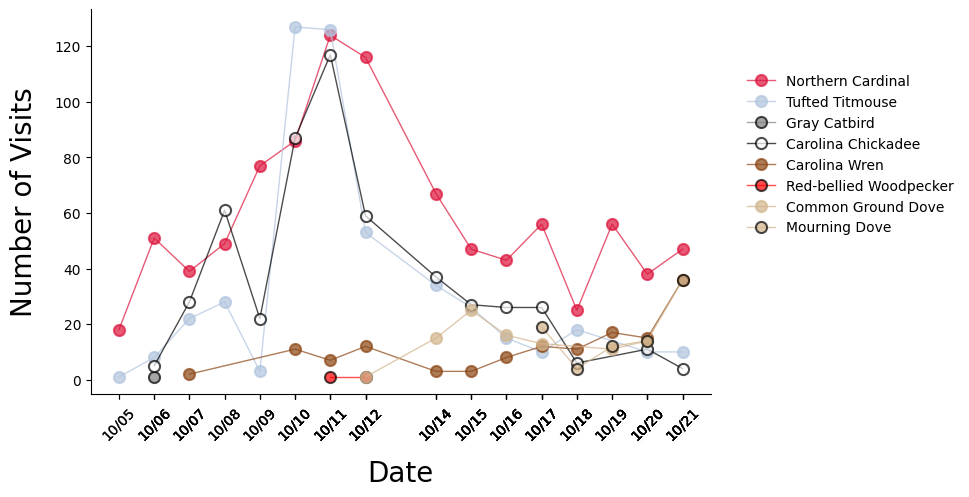

In [77]:
# Define custom colors for each bird species
bird_colors = {
    'Northern Cardinal': '#DC143C',         # Cardinal red
    'Tufted Titmouse': '#B0C4DE',           # Light blue gray
    'Gray Catbird': '#808080',              # Gray
    'Carolina Chickadee': '#FFFFFF',        # White
    'Carolina Wren': '#8B4513',             # Medium brown
    'Red-bellied Woodpecker': '#FF0000',    # Red
    'Common Ground Dove': '#D2B48C',        # Tan
    'Mourning Dove': '#D2B48C'              # Tan
}

# Define marker edge colors for birds that need black outlines
bird_edge_colors = {
    'Northern Cardinal': '#DC143C',
    'Tufted Titmouse': '#B0C4DE',
    'Gray Catbird': 'black',
    'Carolina Chickadee': 'black',
    'Carolina Wren': '#8B4513',
    'Red-bellied Woodpecker': 'black',
    'Common Ground Dove': '#D2B48C',
    'Mourning Dove': 'black'
}

fig, ax = plt.subplots(figsize=(8, 5))

# Plot each bird species individually with custom colors
for bird in daily_summs['Bird'].unique():
    bird_data = daily_summs[daily_summs['Bird'] == bird]
        # Use different colors for line and marker for Carolina Chickadee
    if bird == 'Carolina Chickadee':
        line_color = '#000000'  # Black line
        marker_color = '#FFFFFF'  # White marker
    else:
        line_color = bird_colors[bird]
        marker_color = bird_colors[bird]
    
    ax.plot(
        bird_data['Date'], 
        bird_data['Feeder Visits'], 
        marker='o', 
        markersize=8,
        markerfacecolor=marker_color,
        markeredgecolor=bird_edge_colors[bird],
        markeredgewidth=1.5,
        linewidth=1,
        color=line_color,
        label=bird, 
        alpha=0.7
    )

ax.set_ylabel('Number of Visits', fontsize=20, labelpad=12)
ax.set_xlabel('Date', fontsize=20, labelpad=12)
ticks = daily_summs['Date']
ax.set_xticks(ticks=ticks, labels=ticks.dt.strftime('%m/%d'), rotation=45)
ax.tick_params(labelsize=10)
for label in ax.get_xticklabels():
    label.set_fontweight('normal')
    label.set_fontfamily('sans-serif')
sns.despine(top=True, right=True)
plt.legend(loc=(1.05, 0.4), frameon=False)
plt.show()

In [47]:
# Build complete data and plot 3D surface using helpers
_time_bins, _time_labels = build_time_bins()
complete_data, time_labels, dates, time_bin_indices, grouped_data = prepare_complete_data(raw_data, _time_bins)
plot_3d_surface(complete_data, dates, time_bin_indices, time_labels)

In [48]:
# # ---------------------------------
# # Sunrise/Sunset helpers
# # ---------------------------------
# import time as time_module

# def get_sunrise_sunset(lat: float, lon: float, target_date: date) -> Tuple[time, time]:
#     """Get sunrise and sunset times for a given date and location using a free API."""
#     try:
#         # Using sunrise-sunset.org API (free, no key required)
#         url = f"https://api.sunrise-sunset.org/json?lat={lat}&lng={lon}&date={target_date}&formatted=0"
#         response = requests.get(url, timeout=10)
#         response.raise_for_status()
        
#         data = response.json()
#         if data['status'] == 'OK':
#             sunrise_utc = datetime.fromisoformat(data['results']['sunrise'].replace('Z', '+00:00'))
#             sunset_utc = datetime.fromisoformat(data['results']['sunset'].replace('Z', '+00:00'))
            
#             # Convert to local time (assuming Eastern Time for Jacksonville)
#             # Note: This is a simple conversion - you might want to use pytz for proper timezone handling
#             sunrise_local = sunrise_utc.replace(tzinfo=None) - pd.Timedelta(hours=5)  # EST
#             sunset_local = sunset_utc.replace(tzinfo=None) - pd.Timedelta(hours=5)    # EST
            
#             return sunrise_local.time(), sunset_local.time()
#         else:
#             print(f"Error getting sunrise/sunset for {target_date}: {data.get('status', 'Unknown error')}")
#             return None, None
#     except Exception as e:
#         print(f"Error fetching sunrise/sunset for {target_date}: {e}")
#         return None, None


# def create_enhanced_time_data(raw_df: pd.DataFrame, 
#                              lat: float = LATITUDE, 
#                              lon: float = LONGITUDE) -> pd.DataFrame:
#     """Create enhanced dataset with sunrise/sunset data for each time bin."""
    
#     # Get unique dates from the data
#     unique_dates = sorted(raw_df['Date'].dt.date.unique())
    
#     # Build time bins
#     time_bins, time_labels = build_time_bins()
    
#     # Create complete grid
#     all_dates = sorted(raw_df['Date'].unique())
#     all_time_bins = list(range(len(time_bins)))
    
#     complete_grid = pd.DataFrame([
#         (date, tb) for date in all_dates for tb in all_time_bins
#     ], columns=['Date', 'TimeBin'])
    
#     # Add time labels
#     complete_grid['TimeLabel'] = complete_grid['TimeBin'].apply(lambda x: time_labels[x])
    
#     # Add sunrise/sunset data
#     print("Fetching sunrise/sunset data...")
#     sunrise_sunset_data = {}
#     for target_date in unique_dates:
#         sunrise, sunset = get_sunrise_sunset(lat, lon, target_date)
#         sunrise_sunset_data[target_date] = {'sunrise': sunrise, 'sunset': sunset}
#         time_module.sleep(0.1)  # Be nice to the API
    
#     # Add sunrise/sunset to grid
#     complete_grid['DateOnly'] = complete_grid['Date'].dt.date
#     complete_grid['Sunrise'] = complete_grid['DateOnly'].apply(
#         lambda x: sunrise_sunset_data.get(x, {}).get('sunrise')
#     )
#     complete_grid['Sunset'] = complete_grid['DateOnly'].apply(
#         lambda x: sunrise_sunset_data.get(x, {}).get('sunset')
#     )
    
#     # Add time period classification
#     def classify_time_period(row):
#         time_bin_time = time_bins[row['TimeBin']]
#         sunrise = row['Sunrise']
#         sunset = row['Sunset']
        
#         if sunrise and sunset:
#             if sunrise <= time_bin_time <= sunset:
#                 return 'Daylight'
#             else:
#                 return 'Dark'
#         return 'Unknown'
    
#     complete_grid['TimePeriod'] = complete_grid.apply(classify_time_period, axis=1)
    
#     # First, we need to add TimeBin to raw_df if it doesn't exist
#     if 'TimeBin' not in raw_df.columns:
#         # Ensure Time column is datetime.time
#         if not np.issubdtype(pd.Series(raw_df['Time']).dtype, np.dtype('O')):
#             raw_df = raw_df.copy()
#             raw_df['Time'] = pd.to_datetime(raw_df['Time'], format='%H:%M:%S').dt.time
        
#         assign_time_bin = assign_time_bin_factory(time_bins)
#         raw_df['TimeBin'] = raw_df['Time'].apply(assign_time_bin)
#         raw_df = raw_df.dropna(subset=['TimeBin'])
    
#     # Merge with actual observation counts
#     grouped_data = raw_df.groupby(['Date', 'TimeBin']).size().reset_index(name='Count')
#     complete_data = complete_grid.merge(grouped_data, on=['Date', 'TimeBin'], how='left').fillna(0)
    
#     return complete_data


In [49]:
# # Create enhanced dataset with sunrise/sunset data
# enhanced_data = create_enhanced_time_data(raw_data)

# # Display sample of the enhanced data
# print("Enhanced dataset shape:", enhanced_data.shape)
# print("\nSample of enhanced data:")
# print(enhanced_data[['Date', 'TimeLabel', 'Sunrise', 'Sunset', 'TimePeriod', 'Count']].head(10))

# # Summary statistics
# print(f"\nTime period distribution:")
# print(enhanced_data['TimePeriod'].value_counts())


In [50]:
# # Test the BackyardEcology API key
# import requests

# def test_api_key():
#     url = "http://api.openweathermap.org/data/2.5/weather"
#     params = {
#         'lat': 30.3322,  # Jacksonville, FL
#         'lon': -81.6557,
#         'appid': 'a960d4678fe1d5866662fa8ce01246f2',
#         'units': 'imperial'
#     }
    
#     try:
#         response = requests.get(url, params=params, timeout=10)
#         print(f"Status Code: {response.status_code}")
#         print(f"Response: {response.text}")
        
#         if response.status_code == 200:
#             data = response.json()
#             print(f"Success! Temperature: {data['main']['temp']}°F")
#             return True
#         else:
#             print("API call failed")
#             return False
#     except Exception as e:
#         print(f"Error: {e}")
#         return False

# test_api_key()


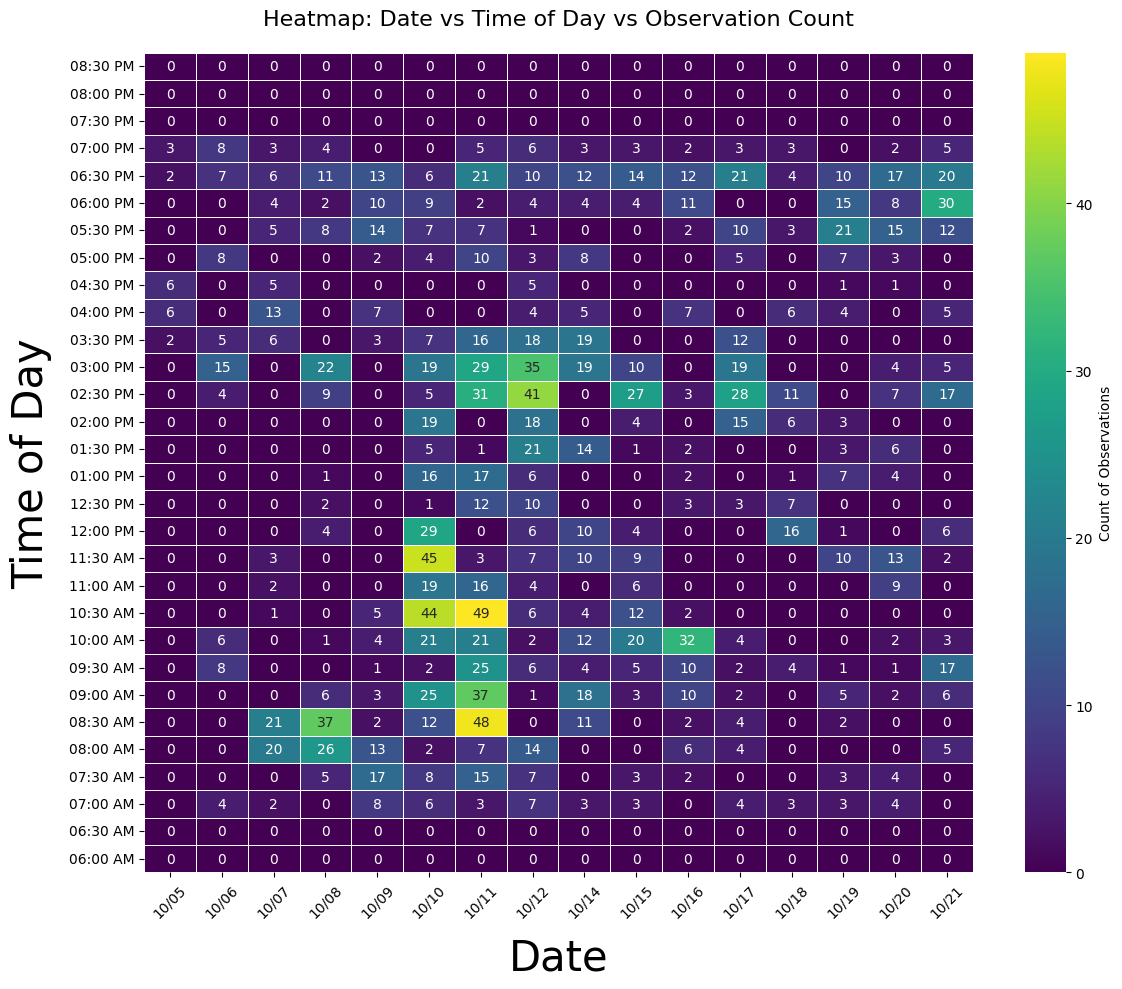

In [51]:
# Reuse prepared data to plot heatmap of counts
plot_heatmap_counts(complete_data, time_labels)

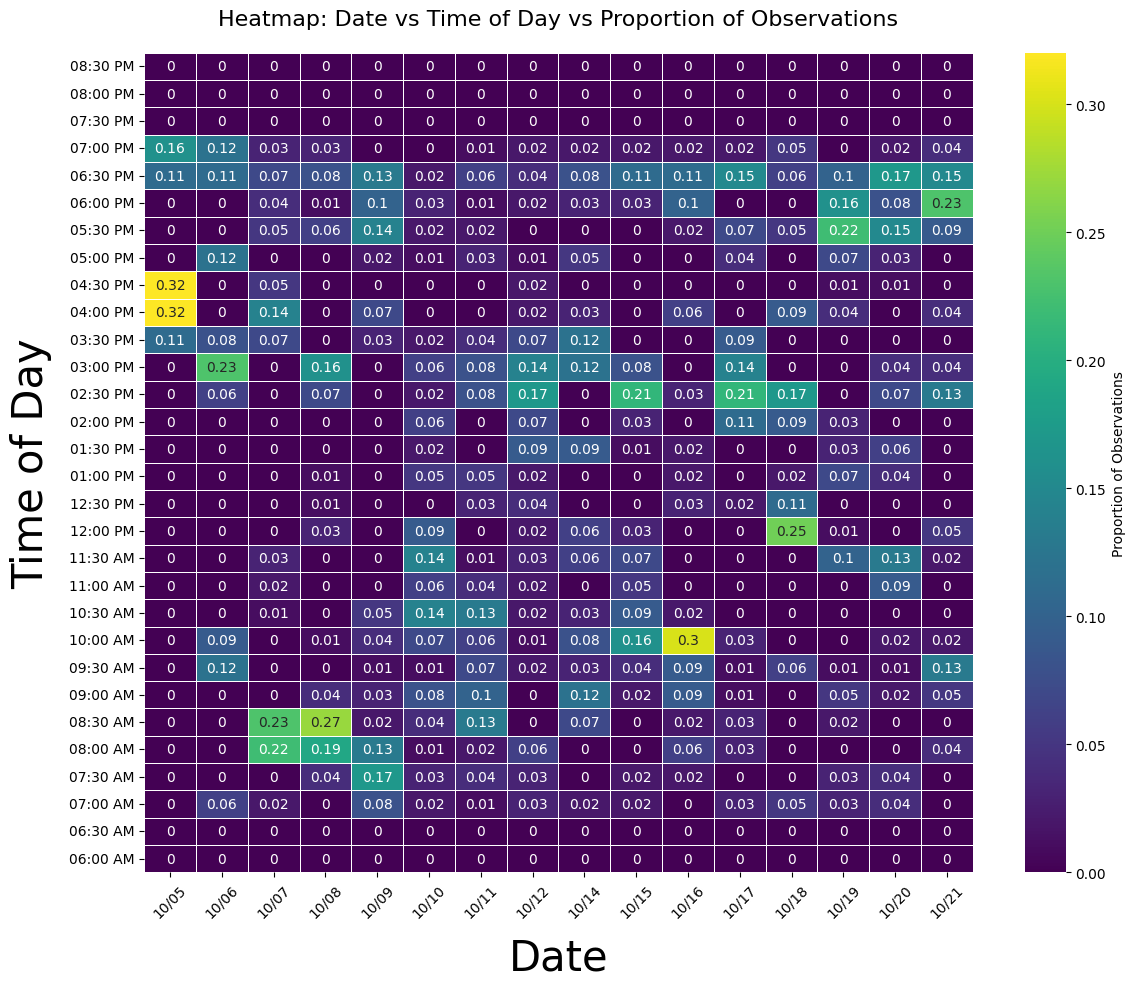

In [52]:
# Heatmap of proportions using helper
plot_heatmap_proportions(complete_data, time_labels)

In [53]:
# Add here
complete_data

,Date,TimeBin,Count
0,2025-10-05,0,0.0
1,2025-10-05,1,0.0
2,2025-10-05,2,0.0
3,2025-10-05,3,0.0
4,2025-10-05,4,0.0
...,...,...,...
475,2025-10-21,25,20.0
476,2025-10-21,26,5.0
477,2025-10-21,27,0.0
478,2025-10-21,28,0.0


# Add Migration Information

In [54]:
bird_cast = pd.read_json(BIRDCAST_JSON)
bird_cast = bird_cast[bird_cast['region_name'] == 'Duval County, Florida'].reset_index(drop=True)
bird_cast['migration_start_utc'] = pd.to_datetime(bird_cast['migration_start_utc'])
# Trim and copy to avoid SettingWithCopyWarning
bird_cast_trim = bird_cast[bird_cast['migration_start_utc'] > '2025-10-02'].copy()
# Scale to millions using .loc assignment
bird_cast_trim.loc[:, 'total_birds'] = bird_cast_trim['total_birds'] / 1_000_000

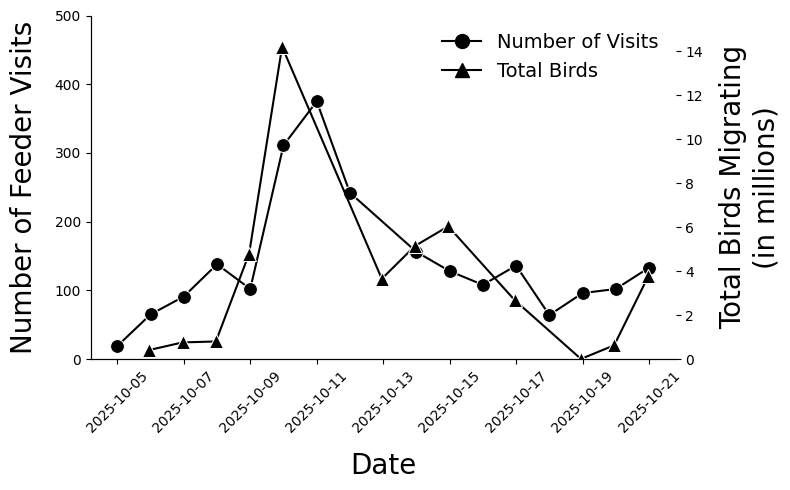

In [55]:
all_birds_feeder = daily_summs.groupby('Date')['Feeder Visits'].sum()
all_birds_feeder = pd.DataFrame(all_birds_feeder).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 5))

# First lineplot on primary y-axis
sns.lineplot(
    x='Date', 
    y='Feeder Visits', 
    data=all_birds_feeder, 
    ax=ax1, 
    marker='o', 
    markersize=10,
    color='black',
    label='Number of Visits',
    legend=False
)

# Create secondary y-axis
ax2 = ax1.twinx()

# Second lineplot on secondary y-axis
sns.lineplot(
    x='migration_start_utc',
    y='total_birds',
    data=bird_cast_trim,
    ax=ax2,
    marker='^',
    markersize=10, 
    color='black', 
    label='Total Birds',
    legend=False
)

# Set custom scale for secondary y-axis
ax2.set_ylim(0, bird_cast_trim['total_birds'].max() * 1.1)
ax1.set_ylim(0, 500)

# Set labels for both axes
ax1.set_ylabel('Number of Feeder Visits', fontsize=20, labelpad=12)
ax1.set_xlabel('Date', fontsize=20, labelpad=12)
ax2.set_ylabel('Total Birds Migrating\n(in millions)', fontsize=20, labelpad=12)

# Style the plot
sns.despine(top=True)

# Create a combined legend manually
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', marker='o', linestyle='-', markersize=10, label='Number of Visits'),
    Line2D([0], [0], color='black', marker='^', linestyle='-', markersize=10, label='Total Birds')
]
plt.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=14)

# Rotate x-axis labels
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Calculating Daily and Weekly Diversity

In [56]:
daily_summs

,Date,Bird,Feeder Visits,Left Pecks,Right Pecks,log(PeckR/PeckL),Pecks/Visit Left,Pecks/Visit Right,log(PVR/PVL)
0,2025-10-05,Northern Cardinal,18,2,55,1.439333,0.111111,3.055556,1.439333
1,2025-10-05,Tufted Titmouse,1,1,3,0.477121,1.000000,3.000000,0.477121
2,2025-10-06,Northern Cardinal,51,3,124,1.616300,0.058824,2.431373,1.616300
3,2025-10-06,Tufted Titmouse,8,1,13,1.113943,0.125000,1.625000,1.113943
4,2025-10-06,Gray Catbird,1,1,2,0.301030,1.000000,2.000000,0.301030
...,...,...,...,...,...,...,...,...,...
67,2025-10-21,Northern Cardinal,47,1,125,2.096910,0.021277,2.659574,2.096910
68,2025-10-21,Carolina Chickadee,4,1,6,0.778151,0.250000,1.500000,0.778151
69,2025-10-21,Carolina Wren,36,215,141,-0.183219,5.972222,3.916667,-0.183219
70,2025-10-21,Tufted Titmouse,10,6,16,0.425969,0.600000,1.600000,0.425969


In [57]:
def calculate_species_richness(daily_summs_df):
    """
    Calculate species richness (number of unique species) per day.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and richness columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    richness = daily.groupby("Date")["Bird"].nunique().reset_index()
    richness.columns = ['Date', 'richness']
    
    return richness

def calculate_shannon_h(daily_summs_df):
    """
    Calculate Shannon H (alpha diversity) per day.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and shannon_H columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    
    # Create pivot table: dates as rows, bird species as columns, feeder visits as values
    day_species = daily.pivot_table(
        index="Date", 
        columns="Bird", 
        values="Feeder Visits", 
        aggfunc="sum", 
        fill_value=0
    )
    
    # Calculate proportions (relative abundance) for each species on each day
    # Replace 0 with NaN to avoid log(0) issues
    p = day_species.div(day_species.sum(axis=1), axis=0).replace(0, np.nan)
    
    # Calculate Shannon H: -sum(p * log(p))
    shannon = (-(p * np.log(p)).sum(axis=1)).reset_index()
    shannon.columns = ['Date', 'shannon_H']
    
    return shannon

def calculate_weekly_sorensen_dissimilarity(daily_summs_df):
    """
    Calculate Sørensen dissimilarity between consecutive weeks.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    daily['week'] = daily['Date'].dt.isocalendar().week
    
    # Create weekly presence/absence matrix (1 if species visited that week, 0 otherwise)
    weekly_presence = (daily.groupby(["week", "Bird"])["Feeder Visits"]
                       .sum().unstack(fill_value=0) > 0).astype(int)
    
    # Calculate Sørensen dissimilarity between consecutive weeks
    sorensen = []
    weeks_sorted = sorted(weekly_presence.index)
    
    for w_prev, w_curr in zip(weeks_sorted[:-1], weeks_sorted[1:]):
        a = weekly_presence.loc[w_prev]  # Previous week species presence
        b = weekly_presence.loc[w_curr]  # Current week species presence
        
        a_sum = a.sum()  # Number of species in previous week
        b_sum = b.sum()  # Number of species in current week
        intersection = (a & b).sum()  # Number of species in both weeks
        
        # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
        denom = (a_sum + b_sum)
        d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
        
        sorensen.append({
            "week": w_curr, 
            "sorensen_dissimilarity": d_s
        })
    
    # Convert to DataFrame
    beta_df = pd.DataFrame(sorensen)
    
    # Get all dates and their weeks
    all_dates = daily[['Date', 'week']].drop_duplicates().sort_values('Date')
    
    # Merge with Sørensen dissimilarity data
    result_df = all_dates.merge(beta_df, on='week', how='left')
    result_df = result_df[['Date', 'sorensen_dissimilarity']]
    
    return result_df

def calculate_rolling_sorensen_dissimilarity(daily_summs_df):
    """
    Calculate Sørensen dissimilarity using rolling 3-day comparisons.
    Compares (7,8,9) days ago to (0,1,2) days ago for each day.
    
    Parameters:
    daily_summs_df: DataFrame with columns ['Date', 'Bird', 'Feeder Visits', ...]
    
    Returns:
    DataFrame with Date and rolling_sorensen_dissimilarity columns
    """
    daily = daily_summs_df.copy()
    daily['Date'] = pd.to_datetime(daily['Date'])
    daily = daily.sort_values('Date').reset_index(drop=True)
    
    # Create daily presence/absence matrix (1 if species visited that day, 0 otherwise)
    daily_presence = (daily.groupby(["Date", "Bird"])["Feeder Visits"]
                      .sum().unstack(fill_value=0) > 0).astype(int)
    
    # Get sorted dates
    dates_sorted = sorted(daily_presence.index)
    
    # Calculate rolling 3-day Sørensen dissimilarity
    sorensen_values = []
    
    for i in range(len(dates_sorted)):
        current_date = dates_sorted[i]
        
        # Define the two 3-day periods to compare
        # Period A: 7-9 days ago (days i-9, i-8, i-7)
        # Period B: 0-2 days ago (days i-2, i-1, i)
        
        period_a_dates = []
        period_b_dates = []
        
        # Get dates for period A (7-9 days ago)
        for offset in [9, 8, 7]:
            if i - offset >= 0:
                period_a_dates.append(dates_sorted[i - offset])
        
        # Get dates for period B (0-2 days ago)
        for offset in [2, 1, 0]:
            if i - offset >= 0:
                period_b_dates.append(dates_sorted[i - offset])
        
        # Only calculate if we have at least one date in each period
        if len(period_a_dates) > 0 and len(period_b_dates) > 0:
            # Get species presence for each period
            period_a_presence = daily_presence.loc[period_a_dates].any(axis=0)  # Any species present in period A
            period_b_presence = daily_presence.loc[period_b_dates].any(axis=0)  # Any species present in period B
            
            # Calculate Sørensen dissimilarity
            a_sum = period_a_presence.sum()  # Number of species in period A
            b_sum = period_b_presence.sum()  # Number of species in period B
            intersection = (period_a_presence & period_b_presence).sum()  # Number of species in both periods
            
            # Sørensen dissimilarity formula: 1 - (2 * intersection) / (a_sum + b_sum)
            denom = (a_sum + b_sum)
            d_s = np.nan if denom == 0 else 1 - (2 * intersection / denom)
            
            sorensen_values.append(d_s)
        else:
            sorensen_values.append(np.nan)
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        'Date': dates_sorted,
        'rolling_sorensen_dissimilarity': sorensen_values
    })
    
    return result_df

# Calculate each metric separately
richness_df = calculate_species_richness(daily_summs)
shannon_df = calculate_shannon_h(daily_summs)
weekly_sorensen_df = calculate_weekly_sorensen_dissimilarity(daily_summs)
rolling_sorensen_df = calculate_rolling_sorensen_dissimilarity(daily_summs)

# Merge all metrics into a single dataframe
diversity_metrics_clean = richness_df.merge(shannon_df, on='Date', how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(weekly_sorensen_df, on='Date', how='outer')
diversity_metrics_clean = diversity_metrics_clean.merge(rolling_sorensen_df, on='Date', how='outer')

# Sort by date
diversity_metrics_clean = diversity_metrics_clean.sort_values('Date').reset_index(drop=True)

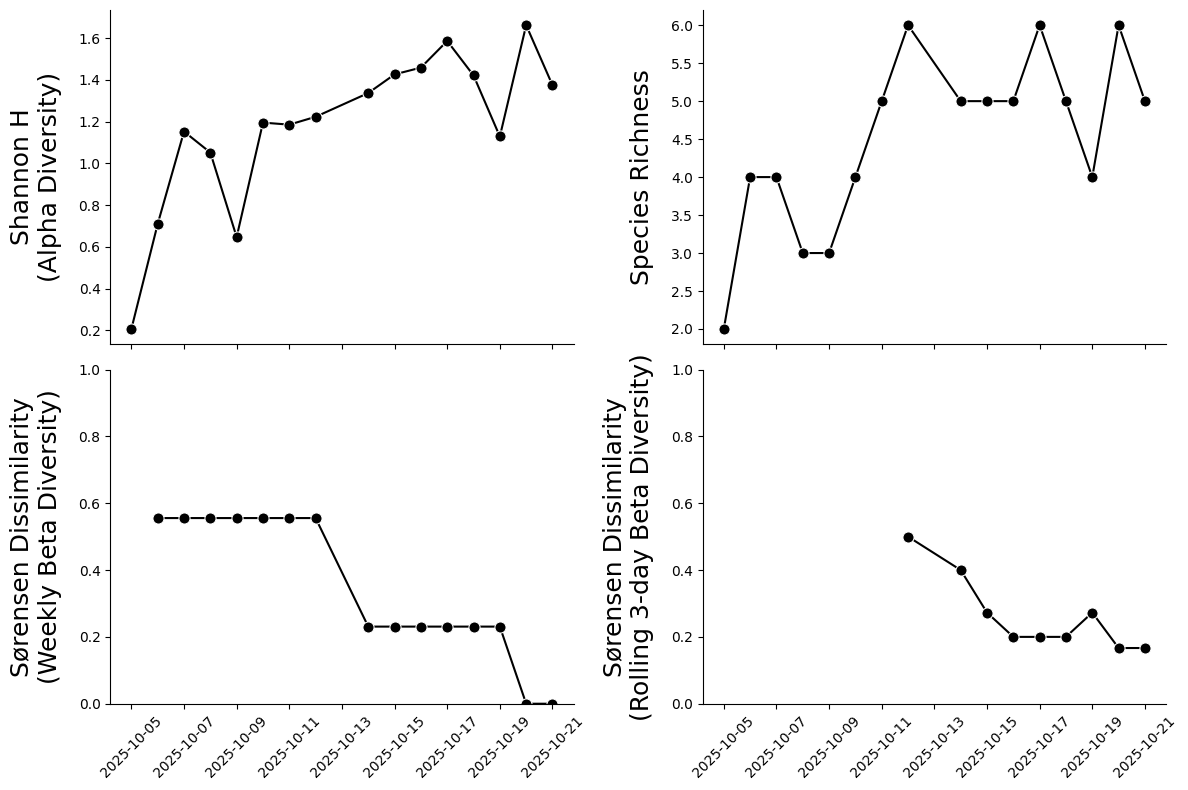


INTERPRETATION OF ALL DIVERSITY METRICS:
• Shannon H (Alpha Diversity) - Top Left:
  - Measures species diversity within each day
  - Higher values = more diverse bird community
  - Considers both species richness and evenness

• Species Richness - Top Right:
  - Simple count of unique bird species per day
  - Higher values = more species present

• Weekly Sørensen Dissimilarity (Beta Diversity) - Bottom Left:
  - Measures how different bird communities are between weeks
  - 0 = identical species composition
  - 1 = completely different species composition

• Rolling 3-day Sørensen Dissimilarity (Beta Diversity) - Bottom Right:
  - Compares species composition between two 3-day periods:
    * Period A: 7-9 days ago
    * Period B: 0-2 days ago
  - Provides more frequent, smoother measure of species turnover
  - Higher values = more rapid changes in species composition


In [58]:
# Create 2x2 subplot layout with all four metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot 1: Shannon H (Alpha Diversity)
sns.lineplot(
    x='Date', 
    y='shannon_H', 
    data=diversity_metrics_clean, 
    ax=ax1, 
    marker='o', 
    markersize=8,
    color='black'
)
ax1.set_ylabel('Shannon H\n(Alpha Diversity)', fontsize=18, labelpad=12)
sns.despine(top=True, right=True, ax=ax1)

# Plot 2: Species Richness
sns.lineplot(
    x='Date', 
    y='richness', 
    data=diversity_metrics_clean, 
    ax=ax2, 
    marker='o', 
    markersize=8,
    color='black'
)
ax2.set_ylabel('Species Richness', fontsize=18, labelpad=12)
sns.despine(top=True, right=True, ax=ax2)

# Plot 3: Weekly Sørensen Dissimilarity (original)
sorensen_weekly_data = diversity_metrics_clean.dropna(subset=['sorensen_dissimilarity'])
if not sorensen_weekly_data.empty:
    sns.lineplot(
        x='Date', 
        y='sorensen_dissimilarity', 
        data=sorensen_weekly_data, 
        ax=ax3, 
        marker='o', 
        markersize=8,
        color='black'
    )
    ax3.set_ylabel('Sørensen Dissimilarity\n(Weekly Beta Diversity)', fontsize=18, labelpad=12)
    ax3.set_ylim(0, 1)
else:
    ax3.text(0.5, 0.5, 'No weekly Sørensen data available\n(need at least 2 weeks)', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)

sns.despine(top=True, right=True, ax=ax3)

# Plot 4: Rolling 3-day Sørensen Dissimilarity (new)
sorensen_rolling_data = diversity_metrics_clean.dropna(subset=['rolling_sorensen_dissimilarity'])
if not sorensen_rolling_data.empty:
    sns.lineplot(
        x='Date', 
        y='rolling_sorensen_dissimilarity', 
        data=sorensen_rolling_data, 
        ax=ax4, 
        marker='o', 
        markersize=8,
        color='black'
    )
    ax4.set_ylabel('Sørensen Dissimilarity\n(Rolling 3-day Beta Diversity)', fontsize=18, labelpad=12)
    ax4.set_ylim(0, 1)
else:
    ax4.text(0.5, 0.5, 'No rolling Sørensen data available\n(need at least 10 days)', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)

sns.despine(top=True, right=True, ax=ax4)

# Rotate x-axis labels for all subplots
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)

for ax in [ax3, ax4]:
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

# Print interpretation
print("\n" + "="*80)
print("INTERPRETATION OF ALL DIVERSITY METRICS:")
print("="*80)
print("• Shannon H (Alpha Diversity) - Top Left:")
print("  - Measures species diversity within each day")
print("  - Higher values = more diverse bird community")
print("  - Considers both species richness and evenness")

print("\n• Species Richness - Top Right:")
print("  - Simple count of unique bird species per day")
print("  - Higher values = more species present")

print("\n• Weekly Sørensen Dissimilarity (Beta Diversity) - Bottom Left:")
print("  - Measures how different bird communities are between weeks")
print("  - 0 = identical species composition")
print("  - 1 = completely different species composition")

print("\n• Rolling 3-day Sørensen Dissimilarity (Beta Diversity) - Bottom Right:")
print("  - Compares species composition between two 3-day periods:")
print("    * Period A: 7-9 days ago")
print("    * Period B: 0-2 days ago")
print("  - Provides more frequent, smoother measure of species turnover")
print("  - Higher values = more rapid changes in species composition")
